In [35]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import glob

import pickle as pkl

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

import emcee
from schwimmbad import MPIPool
from multiprocessing import Pool
from getdist import plots, MCSamples

import scipy

In [36]:
path = glob.glob('/home/laclavere/Documents/Thesis/Pipeline/test/maps/CMB_noiseless_wo_convolutions_nsub_in=20_out=16*')[0]

ifreq = 0
istk = 1

In [37]:
pkl_file = pkl.load(open(path, 'rb'))

In [38]:
maps = pkl_file['maps']
input_maps = pkl_file['maps_in']
fwhm_rec = pkl_file['fwhm_rec']

fwhm_qubic = pkl_file['fwhm_in']
nrec = pkl_file['parameters']['QUBIC']['nrec']
fsub_out = int(pkl_file['parameters']['QUBIC']['nsub_out'] / nrec)
fwhm_mean = np.array([])
for irec in range(nrec):
    fwhm_mean = np.append(fwhm_mean, np.mean(fwhm_qubic[irec*fsub_out:(irec+1)*fsub_out]))


coverage = pkl_file['coverage']
covnorm = coverage / coverage.max()
seenpix = covnorm > 0.2

In [39]:
print(fwhm_rec)
print(fwhm_mean)

[0.00710086 0.00521723]
[0.00711793 0.0052841 ]


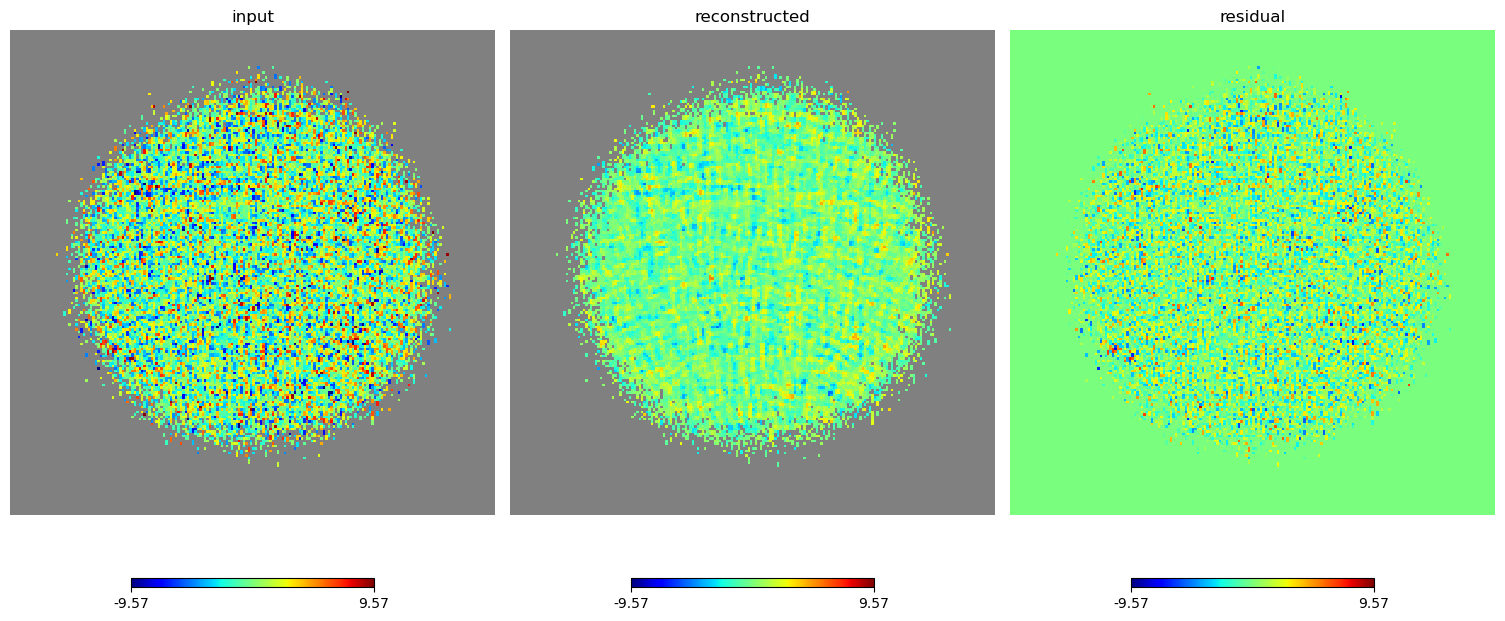

In [40]:
plt.figure(figsize=(15,8))
sigma = np.max([np.std(input_maps[ifreq, seenpix, istk]), np.std(maps[ifreq, seenpix, istk])])
n = 3
hp.gnomview(input_maps[ifreq, :, istk], rot=pkl_file['center'],min=-n*sigma, max=n*sigma, reso=15, notext=True, cmap='jet', title='input', sub=(1, 3, 1))
hp.gnomview(maps[ifreq, :, istk], rot=pkl_file['center'],min=-n*sigma, max=n*sigma, reso=15, notext=True, cmap='jet', title='reconstructed', sub=(1, 3, 2))
hp.gnomview(input_maps[ifreq, :, istk]-maps[ifreq, :, istk], rot=pkl_file['center'],min=-n*sigma, max=n*sigma, reso=15, notext=True, cmap='jet', title='residual', sub=(1, 3, 3))

In [50]:
def minimized_function(fwhm):

        # Define the sky model & the sample variance associated
        if fwhm < 0 or fwhm > 0.1: 
                return - np.inf
        else:
                C = HealpixConvolutionGaussianOperator(fwhm=fwhm)
        
                true_maps = C(input_maps[ifreq,:,istk])
                reconstructed_maps = maps[ifreq,:,istk]
                _r = true_maps[seenpix] - reconstructed_maps[seenpix] 
                return - np.mean(_r**2)

In [51]:
list = []
fwhm_list = np.linspace(0.0001, 0.1, 100)
for i in fwhm_list:
    list.append(-minimized_function(i))

Text(0.5, 1.0, 'Mean difference between pixels of reconstructed map and convoluted input map')

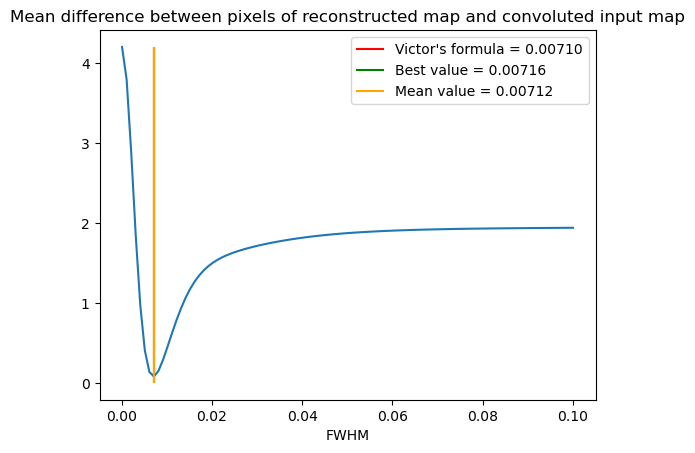

In [52]:
plt.plot(fwhm_list,list)
plt.vlines(pkl_file['fwhm_rec'][ifreq], 0, np.max(list), colors = 'red', label=f"Victor's formula = {pkl_file['fwhm_rec'][ifreq]:.5f}")
plt.vlines(fwhm_list[list.index(np.min(list))], 0, np.max(list), colors = 'green', label=f"Best value = {fwhm_list[list.index(np.min(list))]:.5f}")
plt.vlines(fwhm_mean[ifreq], 0, np.max(list), colors = 'orange', label=f"Mean value = {fwhm_mean[ifreq]:.5f}")
plt.legend()
plt.xlabel('FWHM')
plt.title('Mean difference between pixels of reconstructed map and convoluted input map')

In [44]:
list = []
fwhm_list = np.linspace(0.0001, 0.01, 200)
for i in fwhm_list:
    list.append(-minimized_function(i))

Text(0.5, 1.0, 'Mean difference between pixels of reconstructed map and convoluted input map')

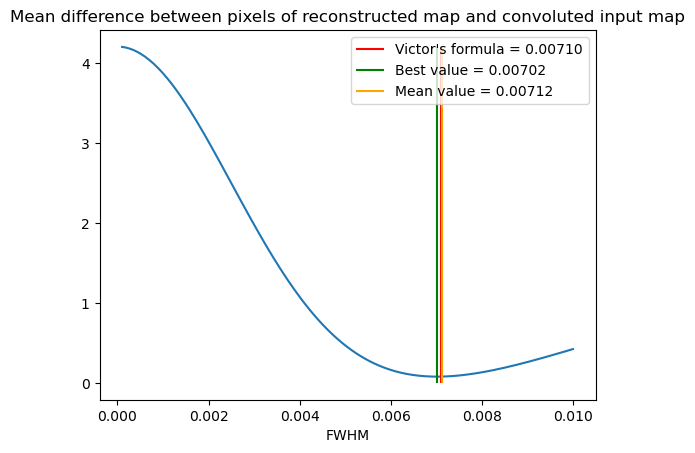

In [45]:
plt.plot(fwhm_list,list)
plt.vlines(pkl_file['fwhm_rec'][ifreq], 0, np.max(list), colors = 'red', label=f"Victor's formula = {pkl_file['fwhm_rec'][ifreq]:.5f}")
plt.vlines(fwhm_list[list.index(np.min(list))], 0, np.max(list), colors = 'green', label=f"Best value = {fwhm_list[list.index(np.min(list))]:.5f}")
plt.vlines(fwhm_mean[ifreq], 0, np.max(list), colors = 'orange', label=f"Mean value = {fwhm_mean[ifreq]:.5f}")
plt.legend()
plt.xlabel('FWHM')
plt.title('Mean difference between pixels of reconstructed map and convoluted input map')

In [46]:
stop

NameError: name 'stop' is not defined

In [ ]:
nwalkers = 30
mcmc_steps = 200
p0 = np.random.rand(nwalkers, 1) * 1e-1
print(p0)

[[0.04546338]
 [0.08629308]
 [0.00306276]
 [0.04830785]
 [0.09957737]
 [0.04220641]
 [0.07717128]
 [0.07383328]
 [0.02799266]
 [0.04874973]
 [0.09924541]
 [0.08961181]
 [0.0394926 ]
 [0.03592326]
 [0.04514815]
 [0.07387616]
 [0.01789547]
 [0.06363151]
 [0.06022044]
 [0.06935097]
 [0.00332621]
 [0.03668927]
 [0.05722085]
 [0.03451571]
 [0.01040802]
 [0.0332487 ]
 [0.03455644]
 [0.0785685 ]
 [0.07535913]
 [0.0229587 ]]


In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, 1, log_prob_fn = minimized_function)
sampler.run_mcmc(p0, mcmc_steps, progress=True)

 90%|████████▉ | 179/200 [36:25<04:36, 13.17s/it]

In [ ]:
discard = 0

samples_flat = sampler.get_chain(flat = True, discard = discard)
samples = sampler.get_chain()

(200, 30, 1)


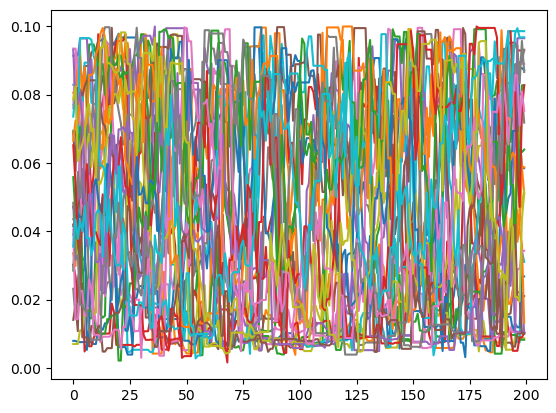

In [ ]:
# Plot the walkers
print(samples.shape)
for i in range(nwalkers):
    plt.plot(samples[:, i])

Removed no burn in


<Figure size 640x480 with 0 Axes>

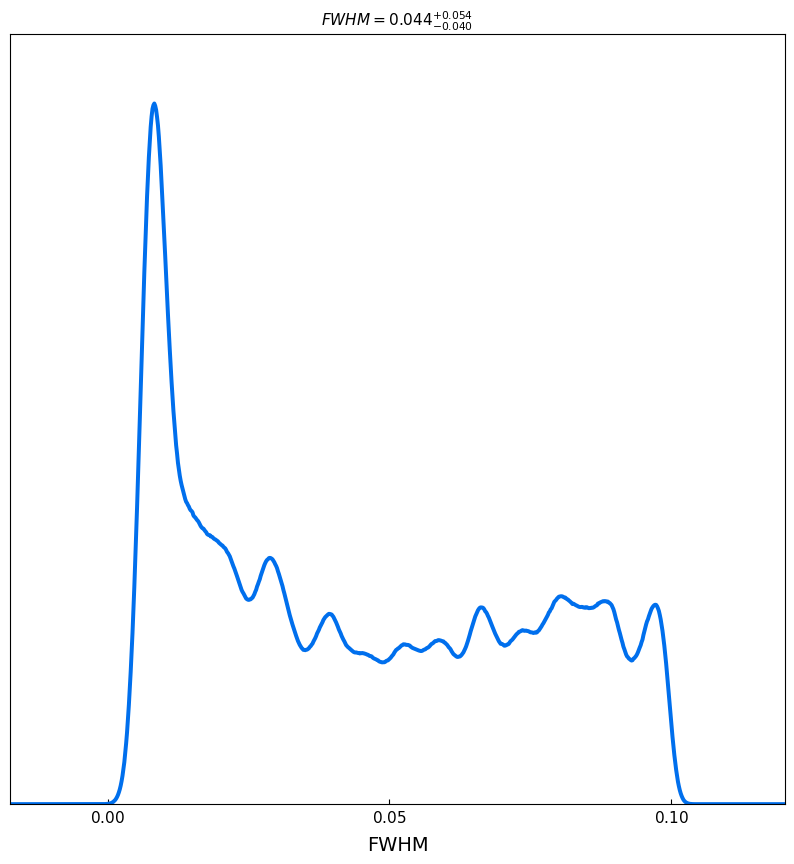

In [ ]:
plt.figure()
g = plots.get_subplot_plotter(width_inch=10)
s = MCSamples(samples=samples_flat, names=['FWHM'])
g.triangle_plot(s, filled=True,title_limit=1)